# Classificação de digitos utilizando o MNIST dataset através de uma CNN
Com o objetivo de aumentar a acurácia do modelo, diversos parâmetros para a construção da CNN serão alterados. Para cada uma das mudanças, um cenário de testes será gerado, com o melhor resultado sendo utilizado nos próximos testes.

## Bibliotecas, definição de parâmetros e preparação dos dados utilizados

In [42]:
import tensorflow as tf
from keras.datasets import mnist
from keras.utils import plot_model
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import pandas as pd
import time

In [92]:
EPOCHS = 30
BATCH_SIZE = 200

In [93]:
seed = 1
tf.random.set_seed(seed)

5


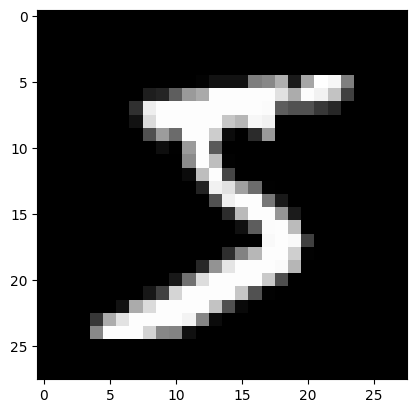

In [94]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.reshape(x_train.shape[0], 28, 28, 1).astype('float32') / 255
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1).astype('float32') / 255

print(y_train[0])
plt.imshow(x_train[0], cmap='gray')
plt.show()

y_train = tf.keras.utils.to_categorical(y_train)
y_test = tf.keras.utils.to_categorical(y_test)

## Classes e métodos
Foram definidas duas classes, uma para servir de callback para nosso método de treino para que possamos anotar o tempo levado para o treinamento e outra classe para facilitar a manipulação dos diversos parâmetros em cada um dos testes. Além disso, para a visualização dos resultados de cada teste, diversos métodos para o plot de gráficos foram criados.

In [95]:
class TrainingTimeCallback(tf.keras.callbacks.Callback) :
    def on_train_begin(self, logs=None) :
        self.times = []
    
    def on_epoch_begin(self, epoch, logs=None) :
        self.epoch_time_start = time.time()
        
    def on_epoch_end(self, epoch, logs=None) :
        self.times.append(time.time() - self.epoch_time_start)    

In [96]:
class CNNModel() :
    def __init__(self, model_name = '', n_conv_layers = 1, n_features = 16, dense_layer_size = 32, early_stopping_patience = None, dropout = None) :

        self.model_name = model_name

        self.n_conv_layers = n_conv_layers
        self.n_features = n_features        
        self.dense_layer_size = dense_layer_size
        self.early_stopping_patience = early_stopping_patience
        self.dropout = dropout
        
        self.model = self.build_model() 
                
    def build_model(self) :
        model = tf.keras.Sequential()
        
        for i in range(self.n_conv_layers) :
            model.add(tf.keras.layers.Conv2D(self.n_features * (i+1), kernel_size=5, input_shape = (28, 28, 1), padding='same', activation='relu'))
            model.add(tf.keras.layers.MaxPooling2D(pool_size=2, padding='same'))      
            
            if (self.dropout != None) :
                model.add(tf.keras.layers.Dropout(self.dropout))  
        
        model.add(tf.keras.layers.Flatten())
        model.add(tf.keras.layers.Dense(self.dense_layer_size, activation='relu'))
        
        if (self.dropout != None) :
                model.add(tf.keras.layers.Dropout(self.dropout))  
                
        model.add(tf.keras.layers.Dense(10, activation='softmax'))
        model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
        return model
    
    def fit(self, x_train, y_train, x_test, y_test) :
        self.training_time = TrainingTimeCallback()
        callbacks = [self.training_time]
        
        if self.early_stopping_patience != None :
            early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=self.early_stopping_patience, restore_best_weights=True)
            callbacks.append(early_stopping)
            
        self.history = self.model.fit(x_train, y_train, validation_data=(x_test, y_test), verbose=0, epochs=EPOCHS, batch_size=BATCH_SIZE, callbacks=callbacks) 
        

In [111]:
# Métodos para visualização dos resultados

def plot_val_accuracy(models) :
    fig, ax = plt.subplots(figsize=(10, 5))

    for model in models :
        ax.plot(model.history.history['val_accuracy'])
    
    ax.set_title('model val accuracy comparison')
    ax.set_ylabel('val accuracy')   
    ax.set_xlabel('epoch') 
    ax.set_xticks(range(0, EPOCHS))
    ax.set_ylim([min(map(lambda model: min(model.history.history['val_accuracy']), models)), 1])

    plt.legend([model.model_name for model in models])
    plt.show()

def plot_training_time(models) :
    fig, ax = plt.subplots()

    for model in models :
        ax.plot(model.training_time.times)
    
    ax.set_title('model training time per epoch')
    ax.set_ylabel('training time (s)')   
    ax.set_xlabel('epoch') 
    ax.set_xticks(range(0, EPOCHS))
    ax.set_ylim([min(map(lambda model: min(model.training_time.times), models)), max(map(lambda model: max(model.training_time.times), models))])

    plt.legend([model.model_name for model in models])
    plt.show()    
    
def plot_total_training_time(models) :
    fig, ax = plt.subplots()

    x = [model.model_name for model in models]
    y = [sum(model.training_time.times) for model in models]

    ax.bar(x, y)
    
    ax.set_title('model total training time')
    ax.set_ylabel('training time (s)')   
    ax.set_xlabel('model') 

    plt.show()    
    
def plot_loss(models) :
    fig, ax = plt.subplots(figsize=(10, 5))
    
    names = []

    for model in models :
        names.append(model.model_name + " LOSS")
        names.append(model.model_name + " VAL LOSS")
        ax.plot(model.history.history['loss'])
        ax.plot(model.history.history['val_loss'], linestyle='dashed', c = ax.get_lines()[-1].get_color())
    
    ax.set_title('model loss comparison')
    ax.set_ylabel('loss')   
    ax.set_xlabel('epoch') 
    ax.set_xticks(range(0, EPOCHS))

    plt.legend(names)
    plt.show()
    
def get_overview(models) :
    overview = []
    
    for model in models :
        name = model.model_name
        train_acc = model.history.history['accuracy'][-1]
        val_acc = model.history.history['val_accuracy'][-1]
        time_spent = sum(model.training_time.times)
        overview.append([name, train_acc, val_acc, time_spent])

    return pd.DataFrame(overview, columns=['Model Name', "Accuracy", "Validation Accuracy", "Training Time"])

## Teste 1 - Quantidade de *convolutional layers*
Para o primeiro teste, usaremos 1, 2 e 3 *convolutional layers*.

In [98]:
# Definição dos modelos
models = [
    CNNModel(model_name='1', n_conv_layers=1, n_features=16, dense_layer_size=32),
    CNNModel(model_name='2', n_conv_layers=2, n_features=16, dense_layer_size=32),
    CNNModel(model_name='3', n_conv_layers=3, n_features=16, dense_layer_size=32)
]

for model in models :
    print("N Conv Layers: ", model.model_name)
    model.model.summary()
    print("\n")

N Conv Layers:  1
Model: "sequential_90"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_153 (Conv2D)         (None, 28, 28, 16)        416       
                                                                 
 max_pooling2d_153 (MaxPooli  (None, 14, 14, 16)       0         
 ng2D)                                                           
                                                                 
 flatten_87 (Flatten)        (None, 3136)              0         
                                                                 
 dense_172 (Dense)           (None, 32)                100384    
                                                                 
 dense_173 (Dense)           (None, 10)                330       
                                                                 
Total params: 101,130
Trainable params: 101,130
Non-trainable params: 0
_____________________________

In [99]:
# Treinamento
for model in models :
    model.fit(x_train, y_train, x_test, y_test)

Para os próximos testes utilizaremos 3 *convolutional layers*, já que obtiveram a melhor acurácia em nossos testes e a diferença de tempo de processamento entre 2 e 3 camadas não foi tão significativa.

,Model Name,Accuracy,Validation Accuracy,Training Time
0,1,0.999567,0.9877,36.524015
1,2,0.997917,0.9903,58.244030
2,3,0.998583,0.9920,77.387045


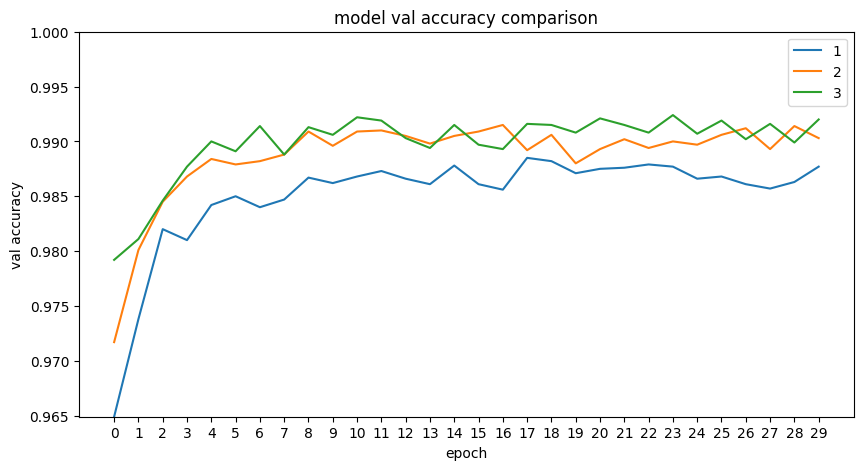

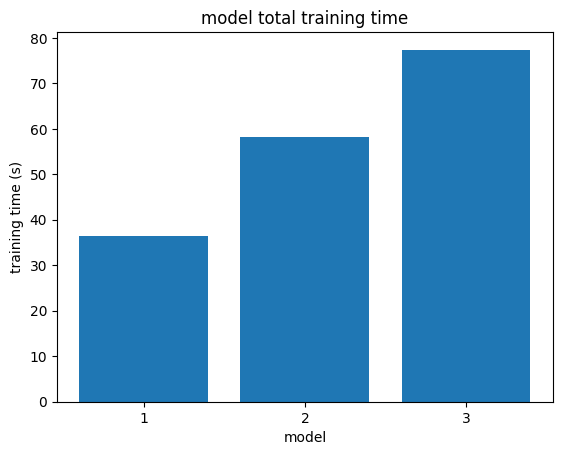

In [106]:
# Resultados
display(get_overview(models))
plot_val_accuracy(models)
plot_total_training_time(models)

Para o primeiro teste, usaremos 1, 2 e 3 *convolutional layers*.

## Teste 2 - Quantidade de *features*
Utilizando o resultado do primeiro teste, usaremos 3 *convolutional layers* para todos os modelos, mas variando o número de *features* em 16, 32, 64 e 128.

In [107]:
# Definição dos modelos
models = [
    CNNModel(model_name='16', n_conv_layers=3, n_features=16, dense_layer_size=32),
    CNNModel(model_name='32', n_conv_layers=3, n_features=32, dense_layer_size=32),
    CNNModel(model_name='64', n_conv_layers=3, n_features=64, dense_layer_size=32),
    CNNModel(model_name='128', n_conv_layers=3, n_features=128, dense_layer_size=32)
]

for model in models :
    print("N Features: ", model.model_name)
    model.model.summary()
    print("\n")

N Features:  16
Model: "sequential_93"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_159 (Conv2D)         (None, 28, 28, 16)        416       
                                                                 
 max_pooling2d_159 (MaxPooli  (None, 14, 14, 16)       0         
 ng2D)                                                           
                                                                 
 conv2d_160 (Conv2D)         (None, 14, 14, 32)        12832     
                                                                 
 max_pooling2d_160 (MaxPooli  (None, 7, 7, 32)         0         
 ng2D)                                                           
                                                                 
 conv2d_161 (Conv2D)         (None, 7, 7, 48)          38448     
                                                                 
 max_pooling2d_161 (MaxPooli  (None, 

In [108]:
# Treinamento
for model in models :
    model.fit(x_train, y_train, x_test, y_test)

32, 64 e 128 features demonstraram um resultado similar, com tempos de treinamento muito distintos entre eles. No teste 3 usaremos 32, 64 e 128 features novamente, com valores diferentes para o *early stopping*.

,Model Name,Accuracy,Validation Accuracy,Training Time
0,16,0.998917,0.9924,79.587236
1,32,0.999333,0.9934,139.748161
2,64,0.999267,0.9929,272.465098
3,128,0.999100,0.9929,468.985175


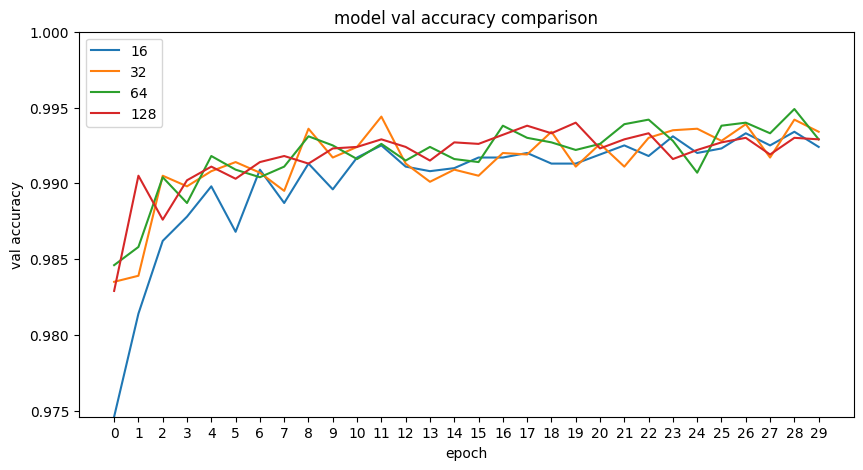

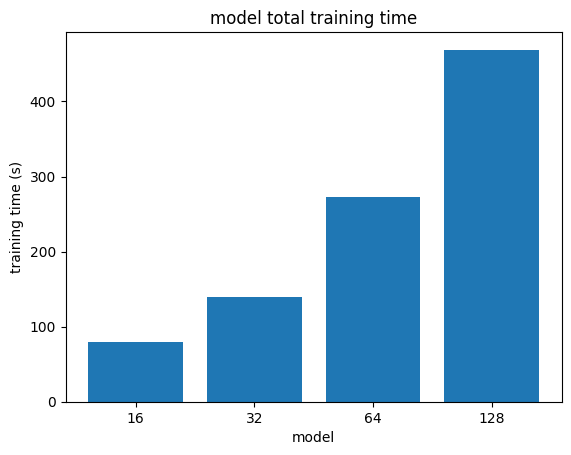

In [109]:
# Resultados
display(get_overview(models))
plot_val_accuracy(models)
plot_total_training_time(models)

## Teste 3 - *Early Stopping*
32, 64 e 128 features serão usadas para os testes, utilizando um valor de *patience* igual a 1, 2, 4 e 8. A métrica observada é a *val accuracy*, com os melhores pesos sendo restaurados.

In [113]:
# Definição dos modelos
models32 = [
    CNNModel(model_name='1', n_conv_layers=3, n_features=32, dense_layer_size=32, early_stopping_patience=1),
    CNNModel(model_name='2', n_conv_layers=3, n_features=32, dense_layer_size=32, early_stopping_patience=2),
    CNNModel(model_name='4', n_conv_layers=3, n_features=32, dense_layer_size=32, early_stopping_patience=4),
    CNNModel(model_name='8', n_conv_layers=3, n_features=32, dense_layer_size=32, early_stopping_patience=8)
]

models64 = [
    CNNModel(model_name='1', n_conv_layers=3, n_features=64, dense_layer_size=32, early_stopping_patience=1),
    CNNModel(model_name='2', n_conv_layers=3, n_features=64, dense_layer_size=32, early_stopping_patience=2),
    CNNModel(model_name='4', n_conv_layers=3, n_features=64, dense_layer_size=32, early_stopping_patience=4),
    CNNModel(model_name='8', n_conv_layers=3, n_features=64, dense_layer_size=32, early_stopping_patience=8)
]

models128 = [
    CNNModel(model_name='1', n_conv_layers=3, n_features=128, dense_layer_size=32, early_stopping_patience=1),
    CNNModel(model_name='2', n_conv_layers=3, n_features=128, dense_layer_size=32, early_stopping_patience=2),
    CNNModel(model_name='4', n_conv_layers=3, n_features=128, dense_layer_size=32, early_stopping_patience=4),
    CNNModel(model_name='8', n_conv_layers=3, n_features=128, dense_layer_size=32, early_stopping_patience=8)
]

In [114]:
# Treinamento
for model in models32 :
    model.fit(x_train, y_train, x_test, y_test)
    
for model in models64 :
    model.fit(x_train, y_train, x_test, y_test)
    
for model in models128 :
    model.fit(x_train, y_train, x_test, y_test)

Os testes realizados indicam que 32 foi o valor mais adequado para o modelo. No entanto, a acurácia com *early stopping* sofreu uma queda.

32 features


,Model Name,Accuracy,Validation Accuracy,Training Time
0,1,0.993267,0.9908,22.054014
1,2,0.995600,0.9906,36.903036
2,4,0.997683,0.9909,68.742033
3,8,0.998367,0.9929,110.056368


64 features


,Model Name,Accuracy,Validation Accuracy,Training Time
0,1,0.986900,0.9849,9.830539
1,2,0.996183,0.9907,32.301740
2,4,0.996917,0.9912,74.202999
3,8,0.998567,0.9924,183.434394


128 features


,Model Name,Accuracy,Validation Accuracy,Training Time
0,1,0.991700,0.9891,45.151275
1,2,0.997717,0.9909,115.475845
2,4,0.998317,0.9920,193.776758
3,8,0.998350,0.9913,422.988345


32 features


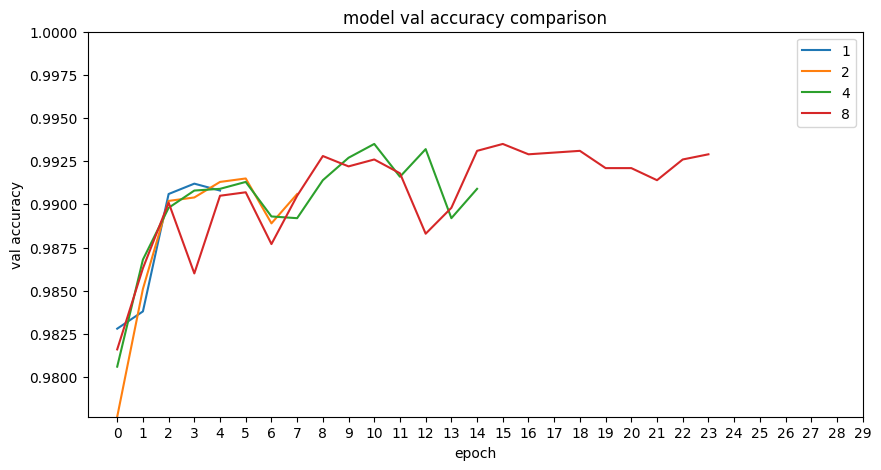

In [118]:
# Resultados
print("32 features")
display(get_overview(models32))

print("64 features")
display(get_overview(models64))

print("128 features")
display(get_overview(models128))

print("32 features")
plot_val_accuracy(models32)

## Teste 4 - *Dropout*
Os modelos para teste utilizarão 3 camadas de convolução, 32 features para a primeira camada e **não** farão uso de *early stopping*. Serão testados *dropouts* de 0.1, 0.2, 0.3, 0.4, 0.5, 0.6 e 0.7.

In [119]:
# Definição dos modelos
models = [
    CNNModel(model_name='0.1', n_conv_layers=3, n_features=32, dense_layer_size=32, dropout=0.1),
    CNNModel(model_name='0.2', n_conv_layers=3, n_features=32, dense_layer_size=32, dropout=0.2),
    CNNModel(model_name='0.3', n_conv_layers=3, n_features=32, dense_layer_size=32, dropout=0.3),
    CNNModel(model_name='0.4', n_conv_layers=3, n_features=32, dense_layer_size=32, dropout=0.4),
    CNNModel(model_name='0.5', n_conv_layers=3, n_features=32, dense_layer_size=32, dropout=0.5),
    CNNModel(model_name='0.6', n_conv_layers=3, n_features=32, dense_layer_size=32, dropout=0.6),
    CNNModel(model_name='0.7', n_conv_layers=3, n_features=32, dense_layer_size=32, dropout=0.7)
]

for model in models :
    print("Dropout: ", model.model_name)
    model.model.summary()
    print("\n")

Dropout:  0.1
Model: "sequential_109"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_207 (Conv2D)         (None, 28, 28, 32)        832       
                                                                 
 max_pooling2d_207 (MaxPooli  (None, 14, 14, 32)       0         
 ng2D)                                                           
                                                                 
 dropout (Dropout)           (None, 14, 14, 32)        0         
                                                                 
 conv2d_208 (Conv2D)         (None, 14, 14, 64)        51264     
                                                                 
 max_pooling2d_208 (MaxPooli  (None, 7, 7, 64)         0         
 ng2D)                                                           
                                                                 
 dropout_1 (Dropout)         (None, 7,

In [120]:
# Treinamento
for model in models :
    model.fit(x_train, y_train, x_test, y_test)

Valores para o dropout de 0.1, 0.3 e 0.4 obtiveram uma acurácia muito similar após o treinamento.

,Model Name,Accuracy,Validation Accuracy,Training Time
0,0.1,0.998367,0.9952,147.645907
1,0.2,0.996133,0.9946,148.132895
2,0.3,0.993033,0.9950,147.182673
3,0.4,0.988783,0.9949,148.366049
4,0.5,0.976817,0.9941,149.232392
5,0.6,0.940950,0.9929,148.217313
6,0.7,0.851050,0.9902,148.500918


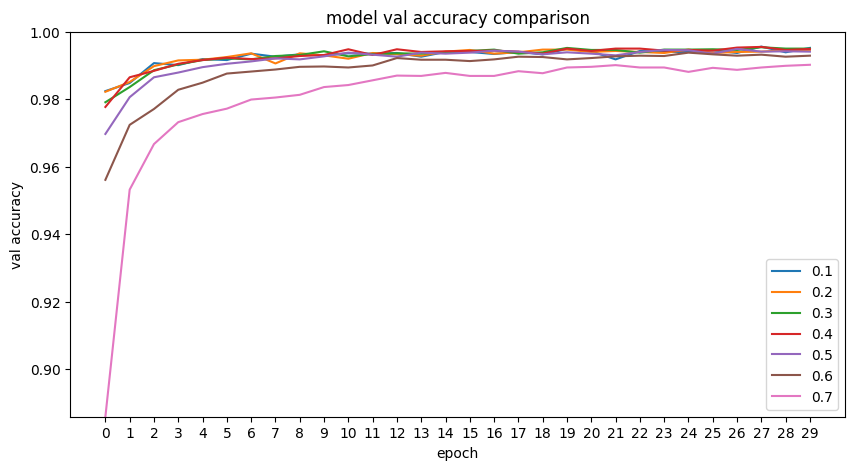

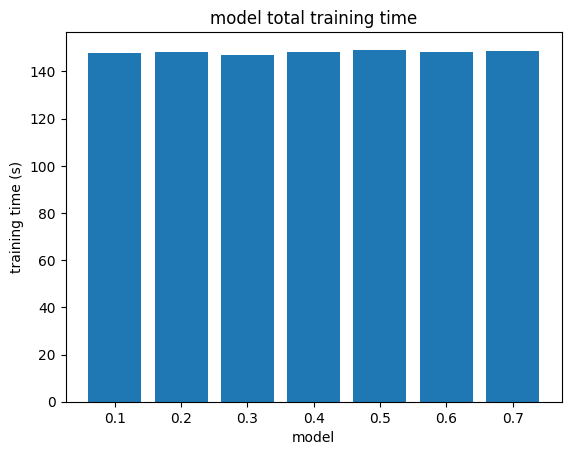

In [121]:
# Resultados
display(get_overview(models))
plot_val_accuracy(models)
plot_total_training_time(models)

Observando as curvas de *loss*, utilizaremos 0.3 para *dropout*, já que além de ter gerado uma acurácia maior, não apresentou nenhum comportamento incomum.

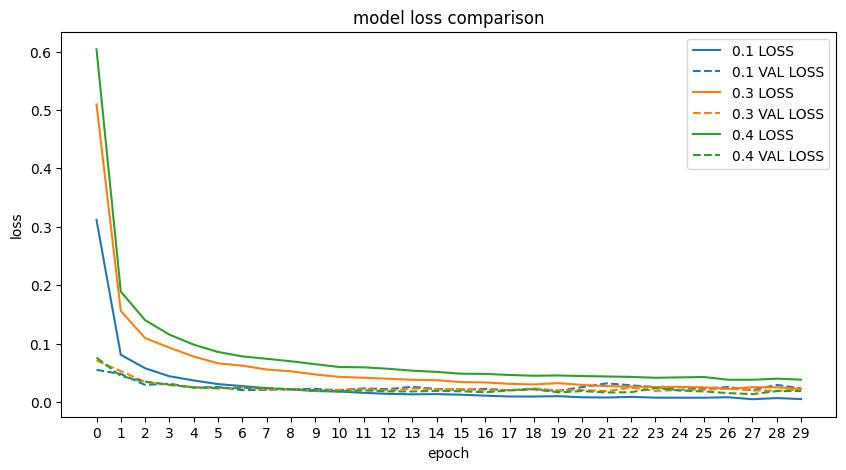

In [122]:
plot_loss([models[0], models[2], models[3]])

## Teste 5 - Tamanho da última camada
Utilizaremos 3 camadas de convolução com 32 *features* iniciais e um *dropout* de 0.3, testando o tamanho da última camada com os valores 16, 32, 64, 128, 256 e 512 .

In [123]:
# Definição dos modelos
models = [
    CNNModel(model_name='16', n_conv_layers=3, n_features=32, dense_layer_size=16, dropout=0.3),
    CNNModel(model_name='32', n_conv_layers=3, n_features=32, dense_layer_size=32, dropout=0.3),
    CNNModel(model_name='64', n_conv_layers=3, n_features=32, dense_layer_size=64, dropout=0.3),
    CNNModel(model_name='128', n_conv_layers=3, n_features=32, dense_layer_size=128, dropout=0.3),
    CNNModel(model_name='256', n_conv_layers=3, n_features=32, dense_layer_size=256, dropout=0.3),
    CNNModel(model_name='512', n_conv_layers=3, n_features=32, dense_layer_size=512, dropout=0.3)
]

for model in models :
    print("Dense Layer Size: ", model.model_name)
    model.model.summary()
    print("\n")

Dense Layer Size:  16
Model: "sequential_116"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_228 (Conv2D)         (None, 28, 28, 32)        832       
                                                                 
 max_pooling2d_228 (MaxPooli  (None, 14, 14, 32)       0         
 ng2D)                                                           
                                                                 
 dropout_28 (Dropout)        (None, 14, 14, 32)        0         
                                                                 
 conv2d_229 (Conv2D)         (None, 14, 14, 64)        51264     
                                                                 
 max_pooling2d_229 (MaxPooli  (None, 7, 7, 64)         0         
 ng2D)                                                           
                                                                 
 dropout_29 (Dropout)        (

In [124]:
# Treinamento
for model in models :
    model.fit(x_train, y_train, x_test, y_test)

Não houveram diferenças significativas entre os diferentes tamanhos para a última camada, com 32 resultando em uma acurácia maior. 

,Model Name,Accuracy,Validation Accuracy,Training Time
0,16,0.979033,0.9946,151.132838
1,32,0.993517,0.9953,149.015673
2,64,0.995833,0.9950,149.052144
3,128,0.996183,0.9944,149.540075
4,256,0.996367,0.9950,149.686221
5,512,0.996600,0.9948,151.751890


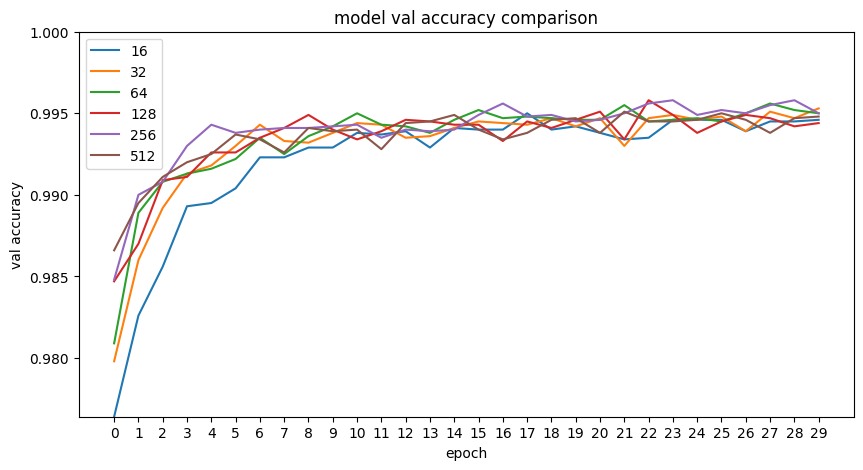

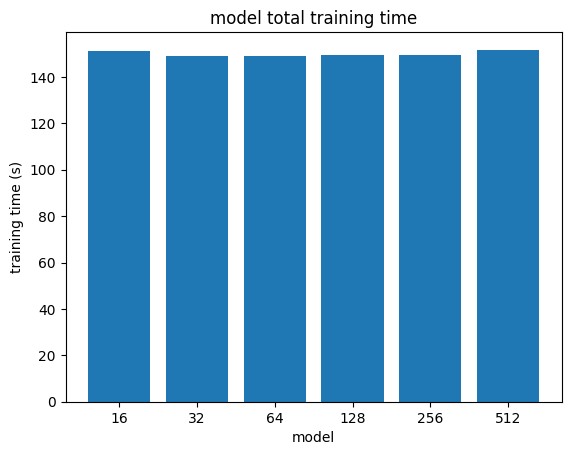

In [125]:
# Resultados
display(get_overview(models))
plot_val_accuracy(models)
plot_total_training_time(models)

## Conclusão

Após os múltiplos testes, os melhores parâmetros encontrados para esse problema, com essa configuração do modelo foram os seguintes:
- Número *convolutional layers* => 3
- Número de *features* => 32
- Tamanho da última camada => 32
- *Dropout* => 0.2
- *Early Stopping* => NA

O melhor modelo do primeiro teste possuía uma *val_accuracy* de 0.9903, enquanto que o melhor modelo do último teste possui um valor de 0.9953, mostrando uma melhora significativa.